<a href="https://colab.research.google.com/github/gwyoun05/Machine-Learning/blob/main/ML_Week8_Seminar_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mlcrate
import tensorflow.keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model, Sequential, load_model 
from tensorflow.keras.layers import Dense, Dropout, Flatten, Embedding,Dot,Add,Subtract,Concatenate
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop, Adam


import mlcrate as mlc
import pickle as pkl
import numpy as np
import pandas as pd
import json
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt 
plt.rcParams['figure.figsize'] = (8, 6) 
import numpy as np
from sklearn.preprocessing import LabelEncoder
import imageio

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train = pd.read_csv('/content/drive/MyDrive/BR_train.csv')

In [4]:
len(train)

229669

In [5]:
test = pd.read_csv('/content/drive/MyDrive/BR_test.csv')

In [6]:
len(test)

25518

In [7]:
test.head()

,User-ID,ISBN
0,5,0505525038
1,9554,0451524233
2,253,0375703713
3,829,0312981961
4,5531,0312244266


In [8]:
train.head(10)

,User-ID,ISBN,Book-Rating
0,0,2226116745,8
1,1,312450109,5
2,2,440211263,7
3,3,312966970,7
4,4,671676571,8
5,5,380973650,9
6,6,385424736,9
7,7,380818078,10
8,8,380789833,9
9,9,312972776,8


In [9]:
train_features = train.iloc[:,:2]

In [10]:
train_features

,User-ID,ISBN
0,0,2226116745
1,1,312450109
2,2,440211263
3,3,312966970
4,4,671676571
...,...,...
229664,150,671021001
229665,7318,006056489X
229666,7538,446525502
229667,3388,316693286


In [11]:
########## Use LabelEncoder for ISBN ##########

In [12]:
ISBN_df = pd.concat([train_features['ISBN'],test['ISBN']])

In [13]:
len(ISBN_df)

255187

In [14]:
le = LabelEncoder()

le.fit(ISBN_df)

train_features['ISBN'] = le.transform(train_features['ISBN'])

test['ISBN'] = le.transform(test['ISBN'])

In [15]:
########## Use LabelEncoder for User-ID ##########

In [16]:
UserID_df = pd.concat([train_features['User-ID'],test['User-ID']])

In [17]:
len(UserID_df)

255187

In [18]:
le = LabelEncoder()

le.fit(UserID_df)

train_features['User-ID'] = le.transform(train_features['User-ID'])

test['User-ID'] = le.transform(test['User-ID'])

In [19]:
train_ratings = train.iloc[:,2]

In [20]:
X_train, X_valid, y_train, y_valid = train_test_split(train_features,train_ratings,test_size=0.2,random_state=22,stratify=train_ratings)

In [21]:
len(X_train)

183735

In [22]:
len(X_valid)

45934

In [23]:
data = pd.concat([train_features,test])

In [24]:
features = ['User-ID','ISBN']
f_size = [int(data[f].max())+3 for f in features]
f_size

[13342, 139466]

In [25]:
Final_X_train = [X_train[f].values for f in features]
Final_X_valid = [X_valid[f].values for f in features]

In [26]:
Final_X_train[1]

array([ 96884,   8686,  93568, ..., 111720,  87137,  78376])

In [27]:
Final_X_test = [test[f].values for f in features]

In [28]:
def get_embed(x_input, x_size, out_dim,test_weights=False):
    # x_input is index of input (either user-id or isbn)
    # x_size is length of vocabulary (e.g. total number of users or isbn)
    # test_weights is a demo flag to show results with predefined weights
    # out_dim is size of embedding vectors
    if x_size > 0: #category
        if test_weights & (out_dim<=2):
            embed = Embedding(x_size, out_dim, input_length=1,
                          weights=[weight_matrix[:x_size,:out_dim]], 
                          embeddings_regularizer=l2(embedding_reg))(x_input)
        else:
            embed = Embedding(x_size, out_dim, input_length=1,
                              embeddings_regularizer=l2(embedding_reg))(x_input)
        embed = Flatten()(embed)
    else:
        embed = Dense(out_dim, kernel_regularizer=l2(embedding_reg))(x_input)
    return embed

In [29]:
f_size

[13342, 139466]

In [30]:
k_latent = 2
embedding_reg = 0.0002 
kernel_reg = 0.1 

In [31]:
dim_input = len(f_size)

input_x = [Input(shape=(1,)) for i in range(dim_input)]
input_x

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'input_2')>]

In [32]:
dim_input
zip(input_x,f_size)

In [33]:
lin_terms = [get_embed(x,size,1) for (x,size) in zip(input_x,f_size)]
lin_terms

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'flatten')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'flatten_1')>]

In [34]:
model = Model(inputs=input_x, outputs=lin_terms)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 1)         13342       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 1)         139466      input_2[0][0]                    
______________________________________________________________________________________________

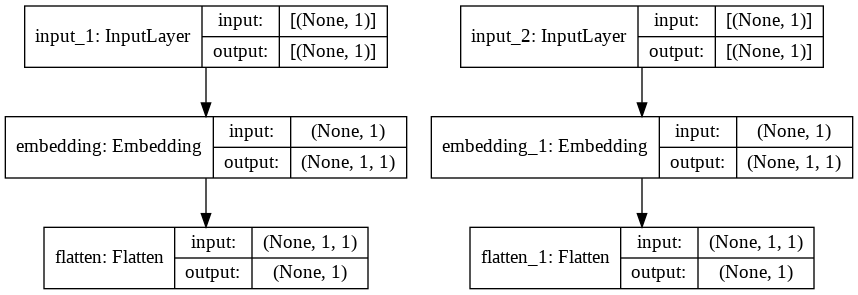

In [35]:
plot_model(model, to_file='modelLinterms.png',show_shapes=True,
           show_layer_names=True)

In [36]:
X_train.dtypes

User-ID    int64
ISBN       int64
dtype: object

In [37]:
Final_X_train[0][6]

1201

In [38]:
lin_terms = model.predict(Final_X_train)

In [39]:
### 3. Factors ###

In [40]:
factors = [get_embed(x, size, k_latent) for (x, size) in zip(input_x, f_size)]
factors

[<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'flatten_2')>,
 <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'flatten_3')>]

In [41]:
input_x = [Input(shape=(1,)) for i in range(dim_input)] 
    
factors = [get_embed(x, size, k_latent) for (x, size) in zip(input_x, f_size)]
model = Model(inputs=input_x, outputs=factors)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1, 2)         26684       input_3[0][0]                    
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 1, 2)         278932      input_4[0][0]                    
____________________________________________________________________________________________

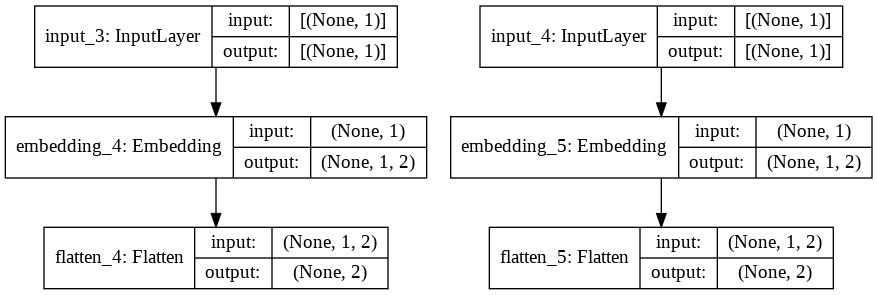

In [42]:
plot_model(model, to_file='modelFactors.png',show_shapes=True,
           show_layer_names=True)

In [43]:
factrs=model.predict(Final_X_train)

In [44]:
len(factrs[0])

183735

In [45]:
factrs[0]

array([[ 0.02171362,  0.02789073],
       [-0.04313849, -0.01462842],
       [ 0.04437348,  0.04507232],
       ...,
       [-0.03719752,  0.01505916],
       [ 0.03806246, -0.02532282],
       [-0.02294854,  0.00118459]], dtype=float32)

In [46]:
### 4. Adding Factors

In [47]:
s = Add()(factors)
s

<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'add')>

In [48]:
inp = [Input(shape=(2,)),Input(shape=(2,))]
add = Model(inp,Add()(inp))
add.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
add_1 (Add)                     (None, 2)            0           input_5[0][0]                    
                                                                 input_6[0][0]                    
Total params: 0
Trainable params: 0
Non-trainable params: 0
__________________________________________________________________________________________________


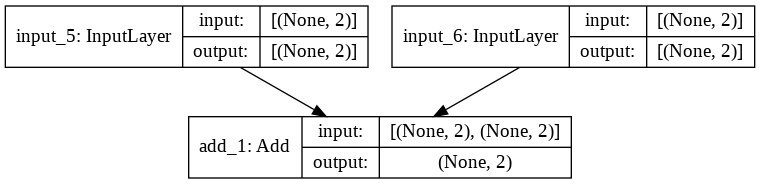

In [49]:
plot_model(add, to_file='modelAdd.png',show_shapes=True,
           show_layer_names=True)

In [50]:
### 5. Calculation of term (S - fj)

In [51]:
diffs = [Subtract()([s, x]) for x in factors]
diffs

[<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'subtract')>,
 <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'subtract_1')>]

In [52]:
s = Input(shape=(2,))
fact = [Input(shape=(2,)),Input(shape=(2,))]
diffs = Model([s]+fact,[Subtract()([s, x]) for x in fact])
diffs.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
subtract_2 (Subtract)           (None, 2)            0           input_7[0][0]                    
                                                                 input_8[0][0]              

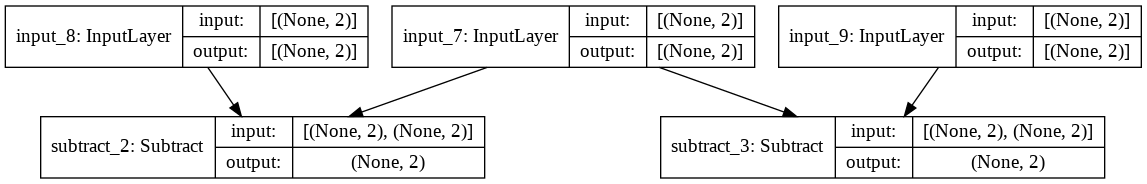

In [53]:
plot_model(diffs, to_file='modelDiff.png',show_shapes=True,
           show_layer_names=True)

In [54]:
### 6. Dot products

In [55]:
dif = [Input(shape=(2,)),Input(shape=(2,))]
fact = [Input(shape=(2,)),Input(shape=(2,))]
dots = Model(dif+fact,
            [Dot(axes=1)([d, x]) for d,x in zip(dif, fact)])
dots.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, 2)]          0                                            
____________________________________________________________________________________________

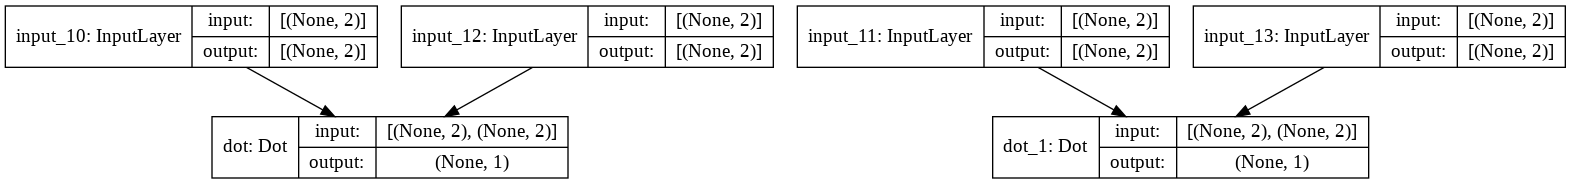

In [56]:
plot_model(dots, to_file='modelDot.png',show_shapes=True,
           show_layer_names=True)

In [57]:
### 7. Putting it all together

In [58]:
def build_model(f_size):
    dim_input = len(f_size)
    
    input_x = [Input(shape=(1,)) for i in range(dim_input)] 
    
    lin_terms = [get_embed(x, size, 1) for (x, size) in zip(input_x, f_size)]

    factors = [get_embed(x, size, k_latent) for (x, size) in zip(input_x, f_size)]
     
    s = Add()(factors)
    
    diffs = [Subtract()([s, x]) for x in factors]
    
    dots = [Dot(axes=1)([d, x]) for d,x in zip(diffs, factors)]
    
    x = Concatenate()(lin_terms + dots)
    x = BatchNormalization()(x)
    output = Dense(1, activation='relu', kernel_regularizer=l2(kernel_reg))(x)
    model = Model(inputs=input_x, outputs=[output])
    model.compile(optimizer=Adam(clipnorm=0.25,learning_rate=0.001), 
                  loss='mean_squared_error',metrics=RootMeanSquaredError())
    return model

In [59]:
model = build_model(f_size)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_15 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 1, 2)         26684       input_14[0][0]                   
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 1, 2)         278932      input_15[0][0]                   
____________________________________________________________________________________________

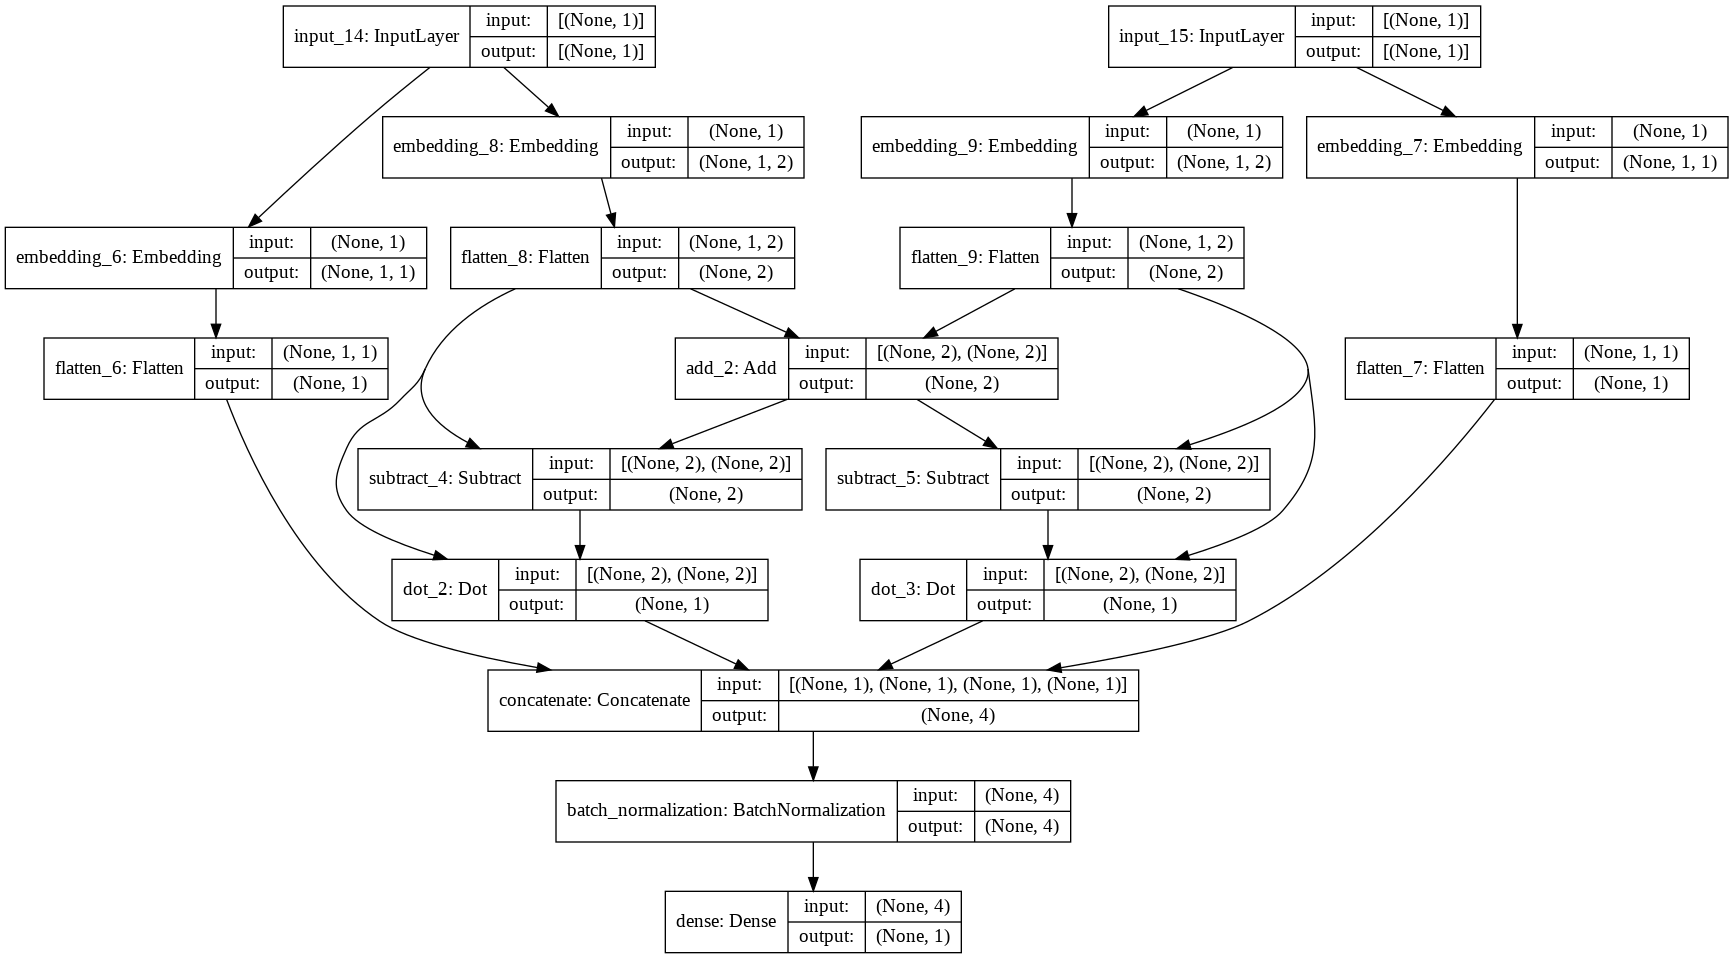

In [60]:
plot_model(model, to_file='modelComplete.png',show_shapes=True,
           show_layer_names=True)

In [61]:
model = build_model(f_size)
earlystopper = EarlyStopping(patience=5, verbose=1,restore_best_weights=True)
t = mlc.time.Timer()
model.fit(Final_X_train,  y_train.values, 
          epochs=200, batch_size=64, verbose=1, shuffle=True, 
          validation_data=(Final_X_valid, y_valid.values), 
          callbacks=[earlystopper]
         )
best_epoch = earlystopper.stopped_epoch

Epoch 1/200
2871/2871 [==============================] - 25s 8ms/step - loss: 13.1997 - root_mean_squared_error: 3.5591 - val_loss: 3.0609 - val_root_mean_squared_error: 1.6050
Epoch 2/200
2871/2871 [==============================] - 23s 8ms/step - loss: 2.3786 - root_mean_squared_error: 1.3977 - val_loss: 3.0698 - val_root_mean_squared_error: 1.6426
Epoch 3/200
2871/2871 [==============================] - 22s 8ms/step - loss: 1.6347 - root_mean_squared_error: 1.1348 - val_loss: 3.2541 - val_root_mean_squared_error: 1.7101
Epoch 4/200
2871/2871 [==============================] - 22s 8ms/step - loss: 1.3906 - root_mean_squared_error: 1.0397 - val_loss: 3.3223 - val_root_mean_squared_error: 1.7374
Epoch 5/200
2871/2871 [==============================] - 22s 8ms/step - loss: 1.2770 - root_mean_squared_error: 0.9947 - val_loss: 3.3372 - val_root_mean_squared_error: 1.7480
Epoch 6/200
2871/2871 [==============================] - 23s 8ms/step - loss: 1.2103 - root_mean_squared_error: 0.9704 

In [64]:
results = model.predict(Final_X_test)

In [65]:
np.savetxt('/content/drive/MyDrive/submission_5_28.csv', results, delimiter=',')